In [1]:
%load_ext autoreload
%autoreload 2

# GoodReads Poetry dataset

The full dataset (including other genres) is available at: https://sites.google.com/eng.ucsd.edu/ucsdbookgraph/home. We focus here on the _Poetry_ dataset for tractability, as it is the one with the least number of books and reviews.

The files in the `./data/goodreads/` directory are:

- `goodreads_books_poetry.json` : contains information about the books (i.e. nodes)
- `reviews.json` : contains reviews of books by users, with the associated timestamp and ratings

Note that the number of reviews is significantly lower than the number of interactions; indeed, "interacting" on goodreads can be "shelving", posting a review, a rating, etc.

In [3]:
import ujson as json
import math
from sklearn.feature_extraction.text import TfidfVectorizer

from lib.Stream import BipartiteStream
from lib.StreamProperties import *
from lib.TimeNode import TimeNode, TimeNodeSet
from datetime import datetime
from lib.Utils import Utils
from lib.patterns import *

# nltk.download("punkt")

DELTA = 36000

We isolate relevant words by TF-IDF (Term Frequency - Inverse Document Frequency) score. For a term i in a document d within corpus D, the the TF-IDF is:
$$
    TFIDF_D(i,d) = tf_{i,d} \cdot \log\left(\frac{|D|}{|\{d \in D : i\in d\}|}\right)
$$

In [4]:
def tf_idf(term, document, corpus):
    # TF
    count = 0
    for i in document:
        if i == term:
            count += 1
    frequency = count / len(document)
    # IDF
    df = 0
    for d in corpus:
        if term in set(d):
            df += 1
    return frequency * math.log10(len(corpus) / df)

Create the template of the JSON file that will hold our data. We will consider that the _left_ side refers to books whereas the _right_ side refers to users.

In [5]:
data_stream = {
"settings": {
    "bipartite": 1,
    "weighted": 0,
    "directed": 0,
    "attributed": 1
},
"T": {
    "alpha": 0,
    "omega": 10
},
"V": {
    "left": [],
    "right": []
},
"W": {},
"E": [],
"I": {
        "left": [],
        "right": []
     }
}

## Prepare books information

In [6]:
books_file = open("data/goodreads/goodreads_books_poetry.json")
books = {}
has_reviews = 0

for (i, line) in enumerate(books_file):
    data = json.loads(line)
    # We add "B-" prefixing each attribute to avoid language duplicates between books and users
    book_attributes = [ "B-" + x for x in map(str.lower, data["description"].split(" ")) ]
    books["B-"+ data["book_id"]] = book_attributes
    # data_stream["I"]["left"] = data_stream["I"]["left"] + book_attributes

## Prepare reviews information

We decide to assign the review text as attributes of the users, and the ndo a matching between the reviews and the book descriptions.

In [13]:
reviews_file = open("data/goodreads/goodreads_reviews_poetry.json")
reviews = []
users_ids = set()
books_ids = set()
labels_users = []
labels_books = []
ratings = {} # sparse matrix ?
links = []
min_date_added = None

for (i,line) in enumerate(reviews_file):
    
    data = json.loads(line)
    
    # Transform date to timestamp
    date_added = datetime.strptime(data["date_added"], "%a %b %d %H:%M:%S %z %Y")
    date_added = date_added.timestamp()
    
    if min_date_added is None or date_added < min_date_added:
        min_date_added = date_added
    
    users_ids.add("U-" + data["user_id"])
    books_ids.add("B-" + data["book_id"])
    reviews.append(data["review_text"])
    
    u = "U-" + data["user_id"]
    v = "B-" + data["book_id"]

    b = date_added - DELTA
    e = date_added + DELTA
    
    # Pick first 5 words of review and description for each node -- FOR TESTS ONLY --
    # map to lowercase
    label_u = [ "U-" + x for x in map(str.lower, set(data["review_text"].split(" "))) ]
    label_v = list(set(books[v]))
    labels_users.extend(label_u)
    labels_books.extend(label_v)
    
    link = {"b": b, "e": e, "u": u, "v": v, "label": { "left": label_v, "right": label_u } }
    links.append(link)

for i in range(0, len(links)):
    links[i]["b"] -= min_date_added
    links[i]["e"] -= min_date_added

data_stream["T"] = {"alpha": 0, "omega": 10 }
data_stream["V"] = {"left": list(books_ids), "right": list(users_ids)}
data_stream["I"] = {"left": list(set(labels_books)), "right": list(set(labels_users))}
data_stream["E"] = links

In [14]:
len(data_stream["V"]["left"]), len(data_stream["V"]["right"]), len(data_stream["I"]["left"]), len(data_stream["I"]["right"]), len(data_stream["E"])

(36412, 47400, 347161, 844212, 154555)

In [15]:
json.dump(data_stream, open("data/goodreads_poetry.json", "w"))

## Create stream

Read from the file that was prepared in the first section of this notebook.

In [16]:
# s = Stream(lang=set(labels_users + labels_books), _fp=open("results.txt", "w+"))
s = BipartiteStream()
s.readStream("data/goodreads_poetry.json")

In [17]:
core_property = StreamStarSat(s, threshold=5)
s.setCoreProperty(core_property)

In [18]:
type(s.core_property) is StreamStarSat, s.core_property.threshold

(True, 5)

In [19]:
len(s.E)

154555

In [21]:
import time
start = time.perf_counter()
#X1 = [TimeNode(x["u"], x["b"], x["e"]) for x in s.E ]
#X2 = [TimeNode(x["v"], x["b"], x["e"]) for x in s.E ]
#X = X1 + X2
#X = TimeNodeSet(elements=X)
#s.W = X
res_int = interior(s)
end = time.perf_counter()
print(end - start)

100.16653640799996


In [23]:
start = time.perf_counter()
r = bipatterns(s, s=2)
end = time.perf_counter()
print(end - start)

,  {B-402128;[196398437.0,196403331.0], B-402128;[50483118.0,50555118.0], B-402128;[278837056.0,278908787.0], B-402128;[300582983.0,300642260.0], B-402128;[162079548.0,162151263.0], B-402128;[35995799.0,36064559.0], B-92270;[54860584.0,54932584.0], B-908708;[52330525.0,52397935.0], B-70885;[161970737.0,162042730.0], B-70885;[49913398.0,49985327.0], B-23534;[32682960.0,32754909.0], B-23534;[55217806.0,55289806.0], B-23534;[36194463.0,36252965.0], B-23534;[281311264.0,281382037.0], B-23534;[191024216.0,191087291.0], B-23534;[161970729.0,162042727.0], B-23534;[341164091.0,341235985.0], B-23534;[49913398.0,49985327.0], B-23534;[187844843.0,187916833.0], B-23534;[43309564.0,43381385.0], B-13105527;[336403447.0,336475023.0], B-1420;[346376515.0,346444588.0], B-1420;[325919895.0,325991596.0], B-1420;[64207919.0,64270757.0], B-1420;[271907973.0,271979162.0], B-1420;[272157565.0,272228679.0], B-1420;[237875717.0,237947705.0], B-1420;[101865966.0,101883019.0], B-1420;[104026666.0,104090373.0], B

KeyboardInterrupt: 

In [103]:
s.fp_close()

In [37]:
list(s.V)[0:10]

['fe488adb521619bebb35028a61c5cdde',
 'b41fd369eec21e02a9ad56c8608c3823',
 'edb780cdc27b4fe316fbc72c1588ed09',
 '5153111a7b8025c21253deb34c995e02',
 'c12609bcc482938019be17a15ee4d171',
 '5290036',
 'bbb6abbad493a606c959f445f2cc793f',
 '38b42c397fd456385bc79356a0feacee',
 '848098',
 '5956803']

In [10]:
vectorizer = TfidfVectorizer(use_idf=True)
res = vectorizer.fit_transform(reviews)

Total number of concepts (i.e. distinct words in reviews)

In [11]:
n_users, n_books, n_reviews, n_concepts = len(users), len(books), len(reviews), len(vectorizer.get_feature_names())
print(f"{n_users} users, {n_books} books, {n_reviews} reviews, {n_concepts} concepts (i.e. distinct words in reviews)")

47400 users, 36412 books, 154555 reviews, 403416 concepts (i.e. distinct words in reviews)


In [12]:
tfidf_values = [round(i, 3) for i in res.data]
len(tfidf_values)

9292775

In [13]:
ccdf_values = Utils.ccdf(tfidf_values)
import numpy as np
np.mean(tfidf_values)

0.09749984294250118

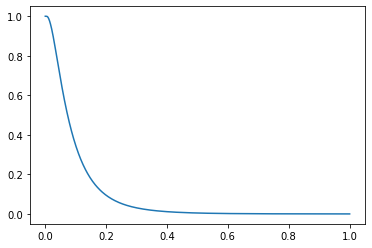

In [14]:
plt.plot(ccdf_values[0], ccdf_values[1])

In [15]:
def parse_review(text, threshold=0.0):
    print(vectorizer.get_feature_names()[143450:143550])

import pandas as pd

In [59]:
# vectorizer.get_feature_names()[i], for a given i, will output the associated word
# However, it's slow, and we don't really need it so far, so we keep to integers indices
filter_tfidf_scores = lambda r: [ (i, v) for i, v in enumerate(r) if v > 0.1 ]
filter_tfidf_scores = lambda r: r.eliminate_zeros() # [ (i, v) for i, v in enumerate(r) if v > 0.1 ]

words_per_review = []
for i, r in enumerate(res):
    if i % 10000 == 0:
        print(i)
    
    tfidf_scores = r.eliminate_zeros().toarray()[0]
    result = filter_tfidf_scores(tfidf_scores)
    words_per_review.append(len(result))

0


AttributeError: 'NoneType' object has no attribute 'toarray'

In [1]:
words_per_review[0]

NameError: name 'words_per_review' is not defined

In [29]:
%history?

Docstring:
::

  %history [-n] [-o] [-p] [-t] [-f FILENAME] [-g [PATTERN [PATTERN ...]]]
               [-l [LIMIT]] [-u]
               [range [range ...]]

Print input history (_i<n> variables), with most recent last.

By default, input history is printed without line numbers so it can be
directly pasted into an editor. Use -n to show them.

By default, all input history from the current session is displayed.
Ranges of history can be indicated using the syntax:

``4``
    Line 4, current session
``4-6``
    Lines 4-6, current session
``243/1-5``
    Lines 1-5, session 243
``~2/7``
    Line 7, session 2 before current
``~8/1-~6/5``
    From the first line of 8 sessions ago, to the fifth line of 6
    sessions ago.

Multiple ranges can be entered, separated by spaces

The same syntax is used by %macro, %save, %edit, %rerun

Examples
--------
::

  In [6]: %history -n 4-6
  4:a = 12
  5:print a**2
  6:%history -n 4-6

positional arguments:
  range

optional arguments:
  -n              